In [1]:
import numpy as np
import pandas as pd
from math import sin, cos, sqrt, atan2, radians
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,ConfusionMatrixDisplay,precision_score,recall_score,roc_curve,roc_auc_score,auc
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 

### Dataset source: https://www.kaggle.com/datasets/kartik2112/fraud-detection

## Data Pre-processing

In [2]:
#Load file
file=pd.read_csv('fraudTrain.csv')
file_test=pd.read_csv('fraudTest.csv')

In [3]:
# delete unnamed column
df = file.loc[:, ~file.columns.str.contains('^Unnamed')]

In [4]:
df.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


### Feature Engineering

In [5]:
#convert latitude and longitude radians for measuring distance
df['radian_lat'] = df.apply(lambda row: radians(row.lat), axis = 1)
df['radian_long'] = df.apply(lambda row: radians(row.long), axis = 1)
df['radian_mlat'] = df.apply(lambda row: radians(row.merch_lat), axis = 1)
df['radian_mlong'] = df.apply(lambda row: radians(row.merch_long), axis = 1)


In [6]:
# Function to Get distance between two points 

# approximate radius of earth in km
def dist(lat1,lon1,lat2,lon2):
    R=6373.0
    dlon=lon2-lon1
    dlat=lat2-lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

In [7]:
# Add new column with distance between owner and merchant
df['ownerToMerdist']= dist(df['radian_lat'],df['radian_long'],df['radian_mlat'],df['radian_mlong'])


In [8]:
df.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,radian_lat,radian_long,radian_mlat,radian_mlong,ownerToMerdist
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0.629694,-1.416825,0.628516,-1.432013,78.622242
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0.853253,-2.063162,0.857987,-2.062743,30.221660
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0.736194,-1.959342,0.753122,-1.957465,108.240051
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0.806876,-1.956755,0.820904,-1.964561,95.703265
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0.670568,-1.386889,0.675006,-1.372395,77.581090


In [9]:
#add date_time column by converting trans_date_trans_time to date time 
df['date_time']=pd.to_datetime(df['trans_date_trans_time'])

In [10]:
# strip out date and time and add as new column
df['date']=df['date_time'].dt.date
df['time']=df['date_time'].dt.time

In [11]:
# strip out hour and add as new column

df['time_hour']=df['date_time'].dt.hour

In [12]:
df.tail(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_fraud,radian_lat,radian_long,radian_mlat,radian_mlong,ownerToMerdist,date_time,date,time,time_hour
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,...,0,0.658295,-1.963106,0.643001,-1.949372,119.789729,2020-06-21 12:12:08,2020-06-21,12:12:08,12
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,...,0,0.685333,-1.352806,0.679053,-1.365660,75.127662,2020-06-21 12:12:19,2020-06-21,12:12:19,12
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,...,0,0.574904,-1.846888,0.586771,-1.834874,99.078827,2020-06-21 12:12:32,2020-06-21,12:12:32,12
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,...,0,0.756646,-1.789680,0.746808,-1.801898,84.654219,2020-06-21 12:13:36,2020-06-21,12:13:36,12
1296674,2020-06-21 12:13:37,4292902571056973207,"fraud_Langosh, Wintheiser and Hyatt",food_dining,4.30,Jeffrey,Smith,M,135 Joseph Mountains,Sula,...,0,0.800117,-1.987490,0.812730,-1.992924,83.879979,2020-06-21 12:13:37,2020-06-21,12:13:37,12


In [13]:
df.head(1).T

,0
trans_date_trans_time,2019-01-01 00:00:18
cc_num,2703186189652095
merchant,"fraud_Rippin, Kub and Mann"
category,misc_net
amt,4.97
first,Jennifer
last,Banks
gender,F
street,561 Perry Cove
city,Moravian Falls


In [14]:
# set today to last date of dateset (Dec 31 2020)
today = datetime.datetime(2020, 12, 31)

In [15]:
today

datetime.datetime(2020, 12, 31, 0, 0)

In [16]:
# convert date of birth to date_time format
df['dob'] =pd.to_datetime(df['dob'], format='%Y/%m/%d')

In [17]:
# set now to last date of dateset (Dec 31 2020)

now = pd.Timestamp('12-31-2020')

In [18]:
# calculate age as of last date of dataset i.e "today"
df['dob'] = df['dob'].where(df['dob'] < now, df['dob'] -  np.timedelta64(100, 'Y'))   
df['age'] = (now - df['dob']).astype('<m8[Y]')    

In [19]:
df.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,radian_lat,radian_long,radian_mlat,radian_mlong,ownerToMerdist,date_time,date,time,time_hour,age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0.629694,-1.416825,0.628516,-1.432013,78.622242,2019-01-01 00:00:18,2019-01-01,00:00:18,0,32.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0.853253,-2.063162,0.857987,-2.062743,30.221660,2019-01-01 00:00:44,2019-01-01,00:00:44,0,42.0


In [20]:
#encode category
encoder_cat = preprocessing.LabelEncoder()
encoder_cat = encoder_cat.fit(df['category'])
df['category_encode'] = encoder_cat.transform(df['category'])

In [21]:
#encode state
encoder_state = preprocessing.LabelEncoder()
encoder_state = encoder_state.fit(df['state'])
df['state_encode'] = encoder_state.transform(df['state'])


## Exploratory Data Analysis (EDA)

In [21]:
# Dataframe with just fraudulant data
fraud_df=df[df['is_fraud']==1]

<AxesSubplot:xlabel='age', ylabel='Count'>

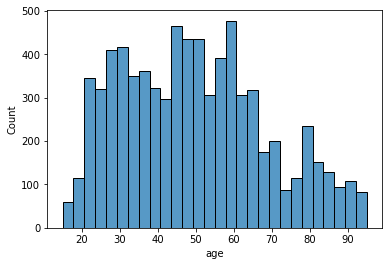

In [22]:
#Distribution of by age for fraudulant transactions
sns.histplot(data=fraud_df, x="age")


<AxesSubplot:xlabel='time_hour', ylabel='Count'>

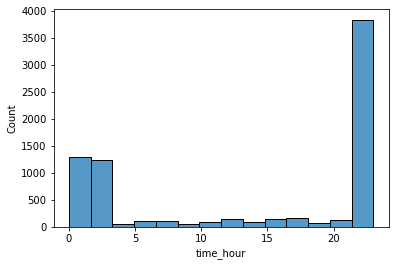

In [23]:
#Distribution of by Time for fraudulant transactions

sns.histplot(data=fraud_df, x="time_hour")


In [24]:
fraud_df.groupby('time_hour').size()


time_hour
0      635
1      658
2      625
3      609
4       46
5       60
6       40
7       56
8       49
9       47
10      40
11      42
12      67
13      80
14      86
15      79
16      76
17      78
18      81
19      81
20      62
21      74
22    1931
23    1904
dtype: int64

<AxesSubplot:xlabel='ownerToMerdist', ylabel='Count'>

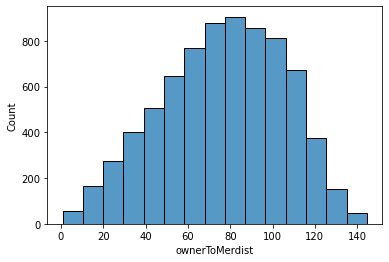

In [25]:
#Distribution of by distance between owner and merchant for fraudulant transactions

sns.histplot(data=fraud_df, x="ownerToMerdist", bins=15)


In [26]:
df.dtypes

trans_date_trans_time            object
cc_num                            int64
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                           object
street                           object
city                             object
state                            object
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
dob                      datetime64[ns]
trans_num                        object
unix_time                         int64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
radian_lat                      float64
radian_long                     float64
radian_mlat                     float64


In [27]:
# convert gender and is_fraud to category
df['is_fraud']=df['is_fraud'].astype("category")
df['gender']=df['gender'].astype("category")

In [28]:
#Table with fraud victim breakdown by Gender
df_plot_gender = df.groupby(['gender', 'is_fraud']).size()
df_plot_gender = df_plot_gender.reset_index()
df_plot_gender = df_plot_gender.rename({0:'count'}, axis=1)

df_plot_gender

,gender,is_fraud,count
0,F,0,706128
1,F,1,3735
2,M,0,583041
3,M,1,3771


In [29]:
#add percentage given that different sample size
male_female=df.groupby(['gender']).size().reset_index().rename({0:'total_gender'}, axis=1)
df_plot_gender=df_plot_gender.merge(male_female,on='gender')
df_plot_gender['percentage']=(df_plot_gender['count']/df_plot_gender['total_gender'])*(100)
df_plot_gender['percentage']=df_plot_gender['percentage'].round(2)

In [30]:
df_plot_gender

,gender,is_fraud,count,total_gender,percentage
0,F,0,706128,709863,99.47
1,F,1,3735,709863,0.53
2,M,0,583041,586812,99.36
3,M,1,3771,586812,0.64


Text(0.5, 0.98, 'Amount of fraud and non-fraud transactions by Gender')

<Figure size 1080x432 with 0 Axes>

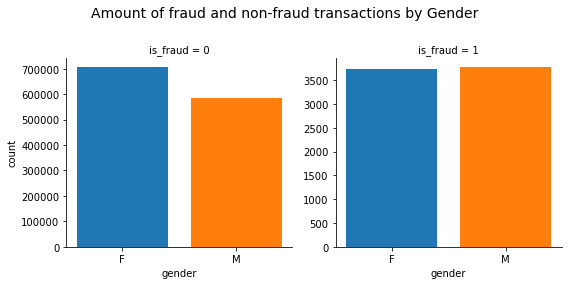

In [31]:
#Plot Count of Fraudulant and non-Fraudulant Transactions by Gender
plt.figure(figsize=(15, 6))
g = sns.FacetGrid(df_plot_gender, col = 'is_fraud', hue = 'gender',sharey=False,height=4, aspect=1)
g.map(plt.bar, 'gender', 'count')
g.fig.subplots_adjust(top=.8)
g.fig.suptitle('Amount of fraud and non-fraud transactions by Gender', fontsize=14)

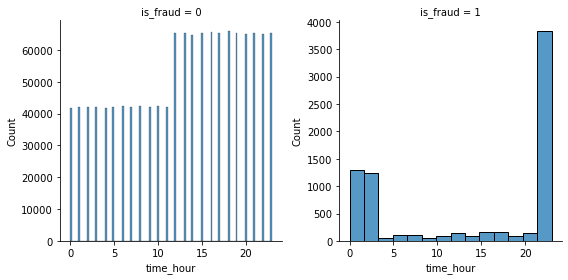

In [32]:
#Distribution of by time for fraudulant vs. non-fradualant transactions

g = sns.FacetGrid(df, col="is_fraud",sharey=False,height=4, aspect=1)
g.map_dataframe(sns.histplot, x="time_hour")

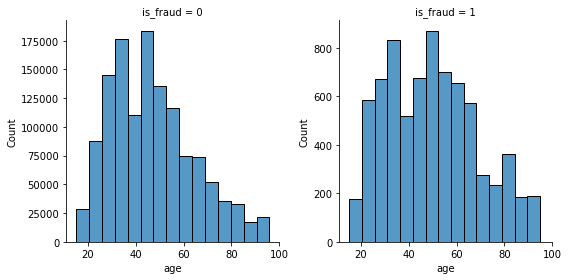

In [33]:
#Distribution of by age for fraudulant vs. non-fradualant transactions

g = sns.FacetGrid(df, col="is_fraud",sharey=False,height=4, aspect=1)
g.map_dataframe(sns.histplot, x="age",bins=15)

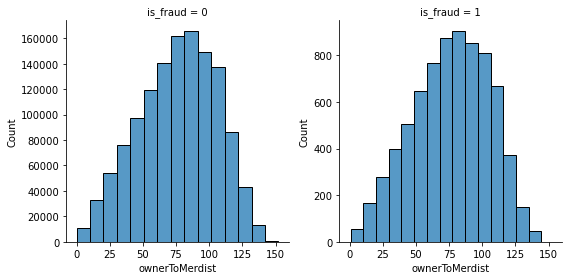

In [34]:
#Distribution of by distance for fraudulant vs. non-fradualant transactions
g = sns.FacetGrid(df, col="is_fraud",sharey=False,height=4, aspect=1)
g.map_dataframe(sns.histplot, x="ownerToMerdist",bins=15)

In [35]:
#Dataframe to plot distributions for time, age, distance between card owner and merchant, and amount of transaction
df_dist = pd.melt(df, id_vars = ['is_fraud'], 
                    value_vars = ['time_hour','age','ownerToMerdist','amt'])
df_dist

,is_fraud,variable,value
0,0,time_hour,0.00
1,0,time_hour,0.00
2,0,time_hour,0.00
3,0,time_hour,0.00
4,0,time_hour,0.00
...,...,...,...
5186695,0,amt,15.56
5186696,0,amt,51.70
5186697,0,amt,105.93
5186698,0,amt,74.90


In [36]:
%matplotlib inline

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 1.6, 'Violin Plot Fraud vs Non-Fraud Transactions')

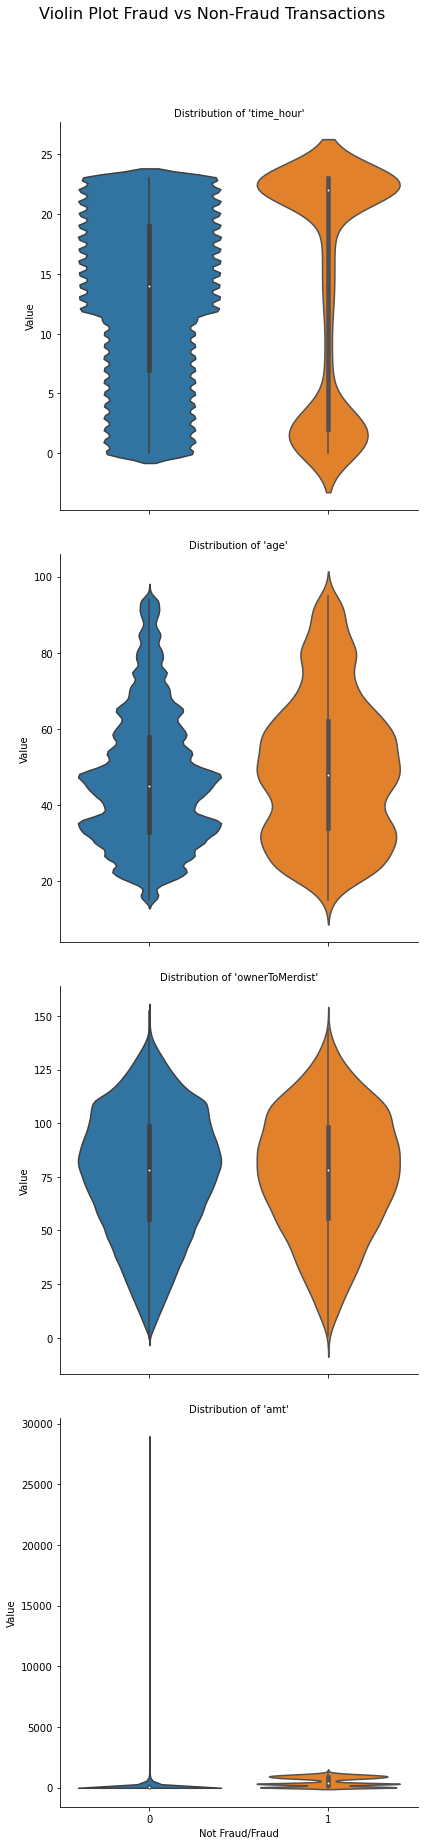

In [37]:
#Facet Grid with Violin plots showing distribution
g = sns.FacetGrid(df_dist, row = 'variable', hue='is_fraud',
                 height=4, aspect=1.5,sharey=False)
g.map(sns.violinplot,"is_fraud",'value')
g.set_titles("Distribution of '{row_name}'")
g.set_axis_labels('Not Fraud/Fraud', 'Value') 
g.fig.subplots_adjust(top=1.5)
g.fig.suptitle('Violin Plot Fraud vs Non-Fraud Transactions',y=1.6,fontsize=16)

In [38]:
df_amt = pd.melt(df, id_vars = ['is_fraud'], 
                    value_vars = ['amt'])
df_amt

,is_fraud,variable,value
0,0,amt,4.97
1,0,amt,107.23
2,0,amt,220.11
3,0,amt,45.00
4,0,amt,41.96
...,...,...,...
1296670,0,amt,15.56
1296671,0,amt,51.70
1296672,0,amt,105.93
1296673,0,amt,74.90


In [39]:
df_amt=df_amt.query("value<5000")

<AxesSubplot:xlabel='is_fraud', ylabel='value'>

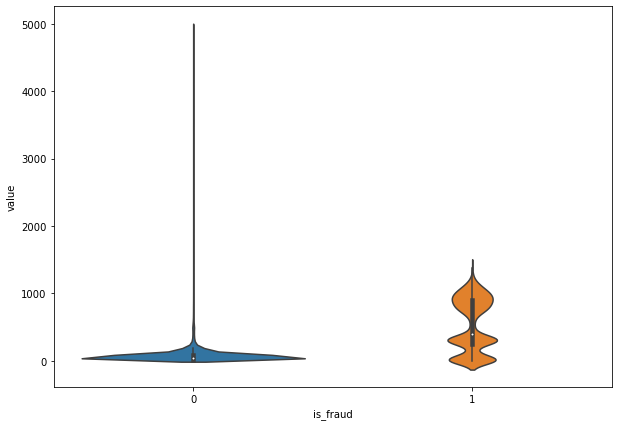

In [40]:
#Violine plot showing distribution of amount
plt.figure(figsize=(10,7))

sns.violinplot(data=df_amt,x='is_fraud',y='value')

In [41]:
# mean, median, 25 percentile, 75 percentile of amount for fraud and non-fraud
def q25(x): return x.quantile(0.25)
def q75(x): return x.quantile(0.75)
df.groupby('is_fraud').agg({'amt':['mean', 'median', q25, q75]}).round(0)


amt                     
           mean median    q25    q75
is_fraud                            
0          68.0   47.0   10.0   83.0
1         531.0  397.0  246.0  901.0

In [45]:
#Table with fraud victim breakdown by category
df_category = df.groupby(['category', 'is_fraud']).size()
df_category = df_category.reset_index()
df_category = df_category.rename({0:'count'}, axis=1)

#add percentage given that different sample size
category=df.groupby(['category']).size().reset_index().rename({0:'total_category'}, axis=1)
df_category=df_category.merge(category,on='category')
df_category['percentage']=(df_category['count']/df_category['total_category'])*(100)
df_category['percentage']=df_category['percentage'].round(2)

df_category

,category,is_fraud,count,total_category,percentage
0,entertainment,0,93781,94014,99.75
1,entertainment,1,233,94014,0.25
2,food_dining,0,91310,91461,99.83
3,food_dining,1,151,91461,0.17
4,gas_transport,0,131041,131659,99.53
5,gas_transport,1,618,131659,0.47
6,grocery_net,0,45318,45452,99.71
7,grocery_net,1,134,45452,0.29
8,grocery_pos,0,121895,123638,98.59
9,grocery_pos,1,1743,123638,1.41


[Text(0.5, 1.0, '% of Fraudulant transactions within the category')]

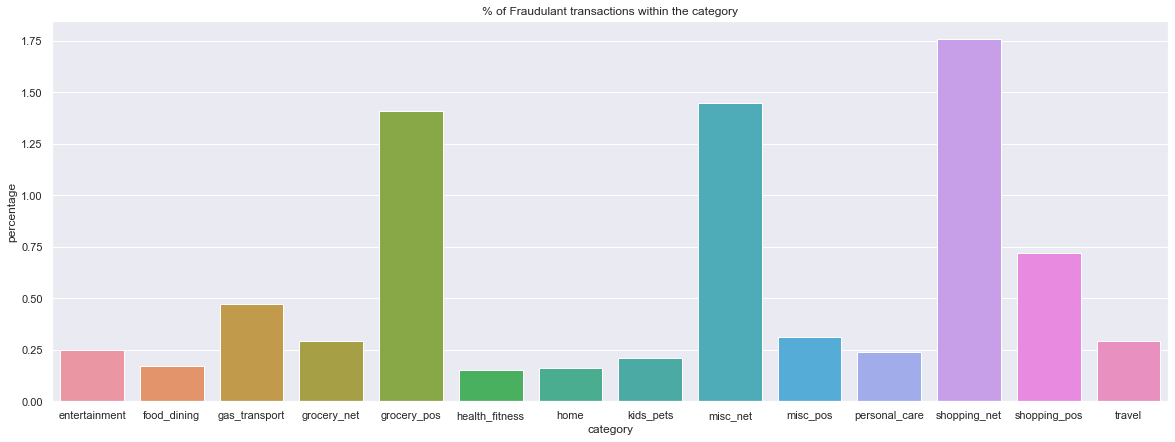

In [58]:
#plot bar chart by category for fraudulant transactions
plt.figure(figsize=(20,7))
sns.barplot(data=df_category[df_category["is_fraud"]==1],x='category',y='percentage').set(title="% of Fraudulant transactions within the category")


[Text(0.5, 1.0, '% of Fraudulant transactions within the State')]

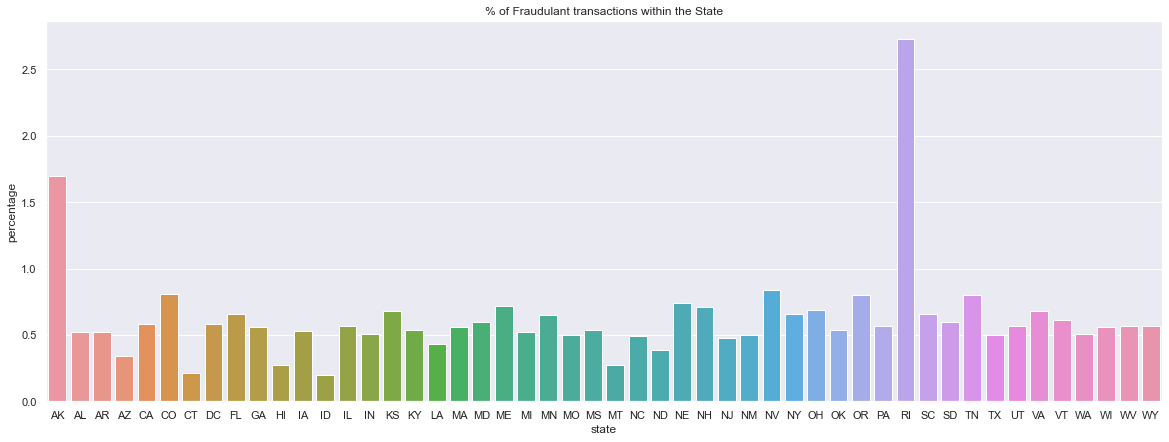

In [76]:
#Table with fraud victim breakdown by state
df_state = df.groupby(['state', 'is_fraud']).size()
df_state = df_state.reset_index()
df_state = df_state.rename({0:'count'}, axis=1)

#add percentage given that different number of transactions per state
state=df.groupby(['state']).size().reset_index().rename({0:'total_state_trans'}, axis=1)
df_state=df_state.merge(state,on='state')
df_state['percentage']=(df_state['count']/df_state['total_state_trans'])*(100)
df_state['percentage']=df_state['percentage'].round(2)

df_state_fraud=df_state[df_state['is_fraud']==1]
#drop deleware because outlier with 100% fraud due to limited data on the state
df_state_fraud = df_state_fraud[df_state_fraud.state != "DE"]
df_state_fraud.reset_index(drop=True,inplace = True)

#plot bar chart by state for fraudulant transactions
plt.figure(figsize=(20,7))
sns.barplot(data=df_state_fraud,x='state',y='percentage').set(title="% of Fraudulant transactions within the State")


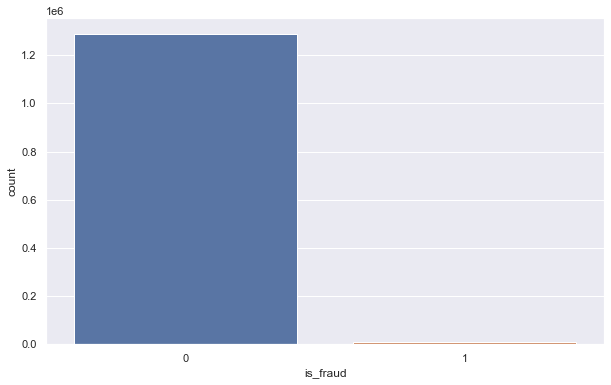

In [42]:
# check if the classes are imbalanced
#Ploting barplot for target 
plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
g = sns.countplot(x="is_fraud", data=df)


In [43]:
df['is_fraud'].value_counts()

0    1289169
1       7506
Name: is_fraud, dtype: int64

## Model Building

In [22]:
#class weights if we use balanced weighting
w0=len(df['is_fraud'])/(2*1289169)
w1=len(df['is_fraud'])/(2*7506)

print(f"weight for no fraud: {w0} , weight for fraud: {w1}")

weight for no fraud: 0.5029111776656126 , weight for fraud: 86.37589928057554


In [23]:
#set up test data frame (i.e data cleaning and feature engineering)
# delete unnamed column
df_test = file_test.loc[:, ~file_test.columns.str.contains('^Unnamed')]
#convert latitude and longitude radians for measuring distance
df_test['radian_lat'] = df_test.apply(lambda row: radians(row.lat), axis = 1)
df_test['radian_long'] = df_test.apply(lambda row: radians(row.long), axis = 1)
df_test['radian_mlat'] = df_test.apply(lambda row: radians(row.merch_lat), axis = 1)
df_test['radian_mlong'] = df_test.apply(lambda row: radians(row.merch_long), axis = 1)
# Add new column with distance between owner and merchant
df_test['ownerToMerdist']= dist(df_test['radian_lat'],df_test['radian_long'],df_test['radian_mlat'],df_test['radian_mlong'])
#add date_time column by converting trans_date_trans_time to date time 
df_test['date_time']=pd.to_datetime(df_test['trans_date_trans_time'])
# strip out date and time and add as new column
df_test['date']=df_test['date_time'].dt.date
df_test['time']=df_test['date_time'].dt.time
# strip out hour and add as new column
df_test['time_hour']=df_test['date_time'].dt.hour
# convert date of birth to date_time format
df_test['dob'] =pd.to_datetime(df_test['dob'], format='%Y/%m/%d')
# calculate age as of last date of dataset i.e "today"
df_test['dob'] = df_test['dob'].where(df_test['dob'] < now, df_test['dob'] -  np.timedelta64(100, 'Y'))   
df_test['age'] = (now - df_test['dob']).astype('<m8[Y]')   
# encode category
df_test['category_encode'] = encoder_cat.transform(df_test['category'])
# encode state
df_test['state_encode'] = encoder_state.transform(df_test['state'])


In [96]:
df_test.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,radian_mlat,radian_mlong,ownerToMerdist,date_time,date,time,time_hour,age,category_encode,state_encode
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,0.593174,-1.417220,24.569172,2020-06-21 12:14:25,2020-06-21,12:14:25,12,52.0,10,40
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,0.688541,-1.919172,104.958031,2020-06-21 12:14:33,2020-06-21,12:14:33,12,30.0,10,44
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,0.706785,-1.294966,59.098624,2020-06-21 12:14:53,2020-06-21,12:14:53,12,50.0,5,34
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,0.502871,-1.411676,27.707262,2020-06-21 12:15:15,2020-06-21,12:15:15,12,33.0,9,9
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,0.784685,-1.498971,104.367859,2020-06-21 12:15:17,2020-06-21,12:15:17,12,65.0,13,22


In [24]:
#get columns to train model
x_train=df[['time_hour','age','ownerToMerdist','amt','category_encode']]
y_train=df[['is_fraud']]

In [25]:
#get columns to test model
x_test=df_test[['time_hour','age','ownerToMerdist','amt',"category_encode"]]
y_test=df_test[['is_fraud']]

## Logistic Regression

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The f1 score for the testing data: 0.10349614229912515


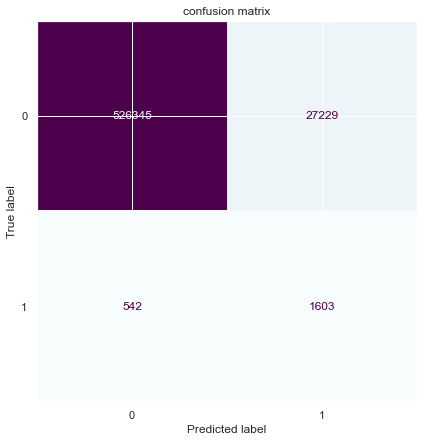

In [114]:
# run logistic regression with balanced class weights

#training the model
lr = LogisticRegression(class_weight='balanced')
lr.fit(x_train, y_train)

# Predicting on the test data
pred_test = lr.predict(x_test)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
cm=confusion_matrix(y_test, pred_test)
fig, ax = plt.subplots(figsize=(7, 7))
disp =ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="BuPu",colorbar=False,ax=ax)
plt.title("confusion matrix")
plt.show()

In [115]:
print(f" Accuracy score: {accuracy_score(y_test, pred_test)}")
print(f" precision_score: {precision_score(y_test, pred_test)}")
print(f" recall_score: {recall_score(y_test, pred_test)}")
print(f" ROC score: {roc_auc_score(y_test, lr.predict_proba(x_test)[::,1])}")


 Accuracy score: 0.9500269020854065
 precision_score: 0.05559794672586015
 recall_score: 0.7473193473193473
 ROC score: 0.847568758597817


### Logistic regression with balanced weights has a high accuracy score but low F1 score

### Use cross validation to find the weights with the optimal F1 score

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

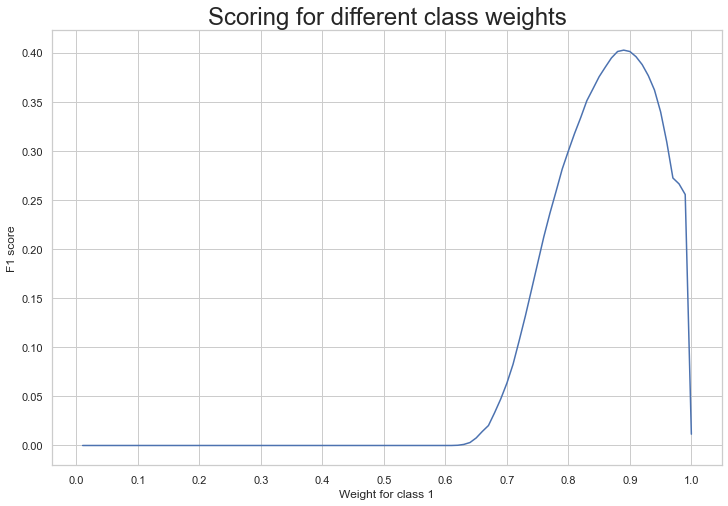

In [73]:
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,100)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(x_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The f1 score for the testing data: 0.354387926215763


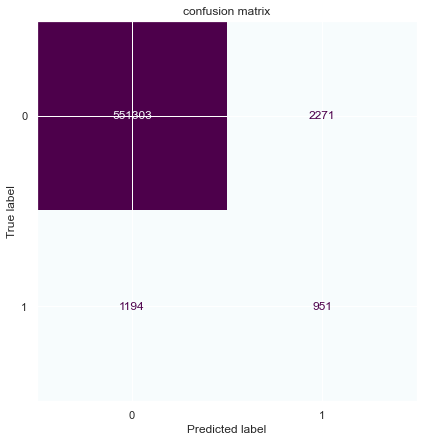

In [109]:
# run logistic regression with updated class weights (0.11 and 0.89)

#importing and training the model
from sklearn.linear_model import LogisticRegression
lr2 = LogisticRegression(class_weight={0: 0.11, 1: 0.89})
lr2.fit(x_train, y_train)

# Predicting on the test data
pred_test2 = lr2.predict(x_test)

#Calculating and printing the f1 score 
f1_test2 = f1_score(y_test, pred_test2)
print('The f1 score for the testing data:', f1_test2)

#Ploting the confusion matrix
cm2=confusion_matrix(y_test, pred_test2)
fig, ax = plt.subplots(figsize=(7, 7))
disp =ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot(cmap="BuPu",colorbar=False,ax=ax)
plt.title("confusion matrix")
plt.show()

In [110]:
print(f" Accuracy score: {accuracy_score(y_test, pred_test2)}")
print(f" precision_score: {precision_score(y_test, pred_test2)}")
print(f" recall_score: {recall_score(y_test, pred_test2)}")
print(f" ROC score: {roc_auc_score(y_test, lr2.predict_proba(x_test)[::,1])}")


 Accuracy score: 0.9937648343857237
 precision_score: 0.2951582867783985
 recall_score: 0.4433566433566434
 ROC score: 0.85442334824748


### F1 score has significantly improved while maintaining high accuracy. But F1 score is still low

### Reduce Threshold since we are less concerned with False Positives and already have a high enough accuracy

In [111]:
#Reduce threshold
threshold = .1
y_pred3=((lr2.predict_proba(x_test)[::,1])>threshold).astype(np.int8) 

print(f" Accuracy score: {accuracy_score(y_test, y_pred3)}")
print(f" precision_score: {precision_score(y_test, y_pred3)}")
print(f" recall_score: {recall_score(y_test, y_pred3)}")
print(f" F1 Score: {f1_score(y_test, y_pred3)}")


 Accuracy score: 0.982327399279132
 precision_score: 0.13982732732732733
 recall_score: 0.6946386946386947
 F1 Score: 0.23279431294430122


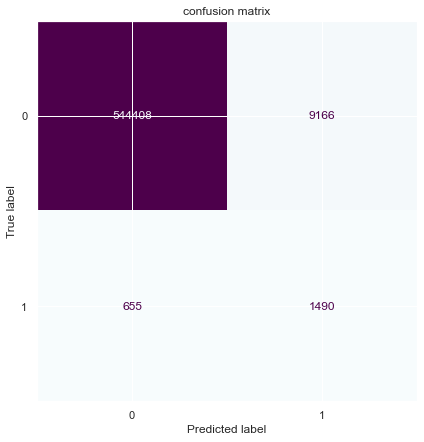

In [112]:
#Ploting the confusion matrix
cm3=confusion_matrix(y_test, y_pred3)
fig, ax = plt.subplots(figsize=(7, 7))
disp =ConfusionMatrixDisplay(confusion_matrix=cm3)
disp.plot(cmap="BuPu",colorbar=False,ax=ax)
plt.title("confusion matrix")
plt.show()

### Have higher true positives but at the detriment of F1 score and accuracy are slightly lower

### Random Forest Model

In [116]:
#get columns to train model
x_train=df[['time_hour','age','ownerToMerdist','amt','category_encode']]
y_train=df[['is_fraud']]
#get columns to test model
x_test=df_test[['time_hour','age','ownerToMerdist','amt','category_encode']]
y_test=df_test[['is_fraud']]

In [117]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100,class_weight='balanced_subsample') 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(x_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(x_test)
 
# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_8612/2554255086.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)



ACCURACY OF THE MODEL:  0.9987619642301235


In [118]:
print(f" Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f" precision_score: {precision_score(y_test, y_pred)}")
print(f" recall_score: {recall_score(y_test, y_pred)}")
f1_test_rf = f1_score(y_test, y_pred)
print('The f1 score for the testing data:', f1_test_rf)

 Accuracy score: 0.9987619642301235
 precision_score: 0.9031543995572773
 recall_score: 0.7608391608391608
The f1 score for the testing data: 0.8259109311740891


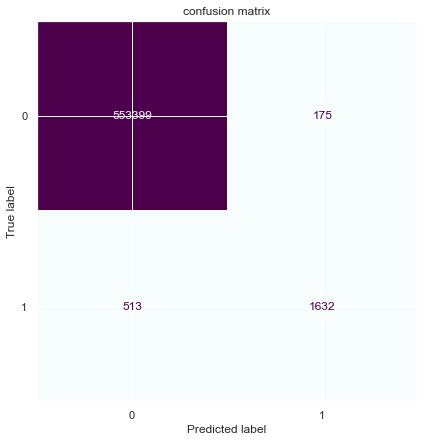

In [119]:
#Ploting the confusion matrix
cmrf=confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp =ConfusionMatrixDisplay(confusion_matrix=cmrf)
disp.plot(cmap="BuPu",colorbar=False,ax=ax)
plt.title("confusion matrix")
plt.show()

### Feature importance for Random Forest 

In [120]:
feature_imp = pd.Series(clf.feature_importances_,index=x_train.columns).sort_values(ascending=False)
feature_imp

amt                0.614883
time_hour          0.214751
category_encode    0.117385
age                0.031425
ownerToMerdist     0.021556
dtype: float64

No handles with labels found to put in legend.


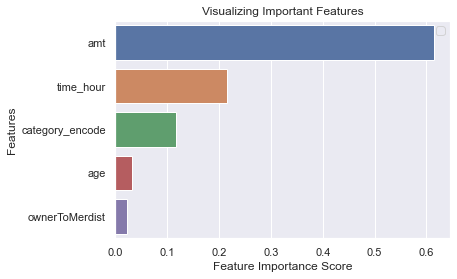

In [121]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### Cross validation and parameter tunning

In [95]:
# generate dataset
x_train, y_train = make_classification(n_samples=1000, random_state=4)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
rf = RandomForestClassifier() 

#Setting the range for class weights
weights = np.linspace(0.0,0.99,5)

#Creating a dictionary grid for grid search
param_grid = {
    "bootstrap": [True],"max_depth": [3,8,20], "max_features": [2, 3,4], "min_samples_leaf": [3, 4, 5],
    "min_samples_split": [8, 10, 12], "n_estimators": [100, 200, 300],
    'class_weight':[{0:x, 1:1.0-x} for x in weights]
}
#Fitting grid search to the train data with 5 folds
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2,scoring="f1")

grid_search.fit(x_train, y_train)
grid_search.best_params_


Fitting 5 folds for each of 1215 candidates, totalling 6075 fits


{'bootstrap': True,
 'class_weight': {0: 0.495, 1: 0.505},
 'max_depth': 8,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 300}

### Model with updated parameters

In [96]:
#get columns to train model
x_train=df[['time_hour','age','ownerToMerdist','amt','category_encode']]
y_train=df[['is_fraud']]
#get columns to test model
x_test=df_test[['time_hour','age','ownerToMerdist','amt',"category_encode"]]
y_test=df_test[['is_fraud']]

# creating a RF classifier
rf2 = RandomForestClassifier(n_estimators = 300,class_weight={0: 0.495, 1: 0.505},max_depth=8,max_features=4,
                             min_samples_leaf= 3,min_samples_split= 12 ) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
rf2.fit(x_train, y_train)
 
# performing predictions on the test dataset
y_pred = rf2.predict(x_test)
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_14972/1278904088.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf2.fit(x_train, y_train)


ACCURACY OF THE MODEL:  0.9986665922885487


 Accuracy score: 0.9986665922885487
 precision_score: 0.9011428571428571
 recall_score: 0.7351981351981351
The f1 score for the testing data: 0.8097560975609756


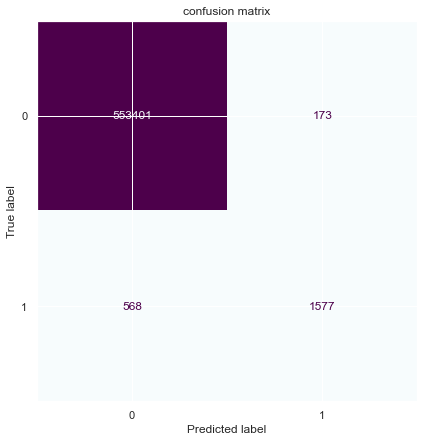

In [97]:
print(f" Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f" precision_score: {precision_score(y_test, y_pred)}")
print(f" recall_score: {recall_score(y_test, y_pred)}")
f1_test_rf = f1_score(y_test, y_pred)
print('The f1 score for the testing data:', f1_test_rf)
#Ploting the confusion matrix
cmrf2=confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp =ConfusionMatrixDisplay(confusion_matrix=cmrf2)
disp.plot(cmap="BuPu",colorbar=False,ax=ax)
plt.title("confusion matrix")
plt.show()

### Reduce Thresholds

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'F1 and Recall scores by Thresholds-RF')

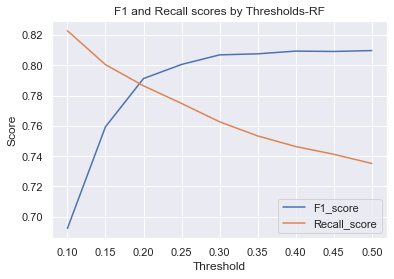

In [98]:
# Find thresholds that keeps F1 score high while achieving high recall score
thresholds = np.arange(0.1, 0.55, 0.05)

f1_thres=pd.DataFrame(columns=['Threshold','F1_score','Recall_score'])
for i in thresholds:
    y_pred4=((rf2.predict_proba(x_test)[::,1])>i).astype(np.int8) 
    f1=f1_score(y_test, y_pred4)
    recall=recall_score(y_test, y_pred4)
    f1_thres=f1_thres.append({'Threshold': i,'F1_score':f1,'Recall_score':recall}, ignore_index=True)

#Plot
fig, ax = plt.subplots()
ax=sns.lineplot(f1_thres['Threshold'], f1_thres['F1_score'])
ax1 = sns.lineplot(f1_thres['Threshold'], f1_thres['Recall_score'])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(labels=["F1_score","Recall_score"])
plt.title("F1 and Recall scores by Thresholds-RF")

In [99]:
f1_thres

,Threshold,F1_score,Recall_score
0,0.10,0.692293,0.822844
1,0.15,0.759398,0.800466
2,0.20,0.791276,0.786480
3,0.25,0.800578,0.774825
4,0.30,0.806905,0.762704
5,0.35,0.807596,0.753380
6,0.40,0.809403,0.746387
7,0.45,0.809160,0.741259
8,0.50,0.809756,0.735198


In [100]:
#Reduce threshold
threshold = .2
y_pred4=((rf2.predict_proba(x_test)[::,1])>threshold).astype(np.int8) 

print(f" Accuracy score: {accuracy_score(y_test, y_pred4)}")
print(f" precision_score: {precision_score(y_test, y_pred4)}")
print(f" recall_score: {recall_score(y_test, y_pred4)}")
print(f" F1 Score: {f1_score(y_test, y_pred4)}")

 Accuracy score: 0.9983984711697819
 precision_score: 0.7961302501179802
 recall_score: 0.7864801864801865
 F1 Score: 0.7912757973733584


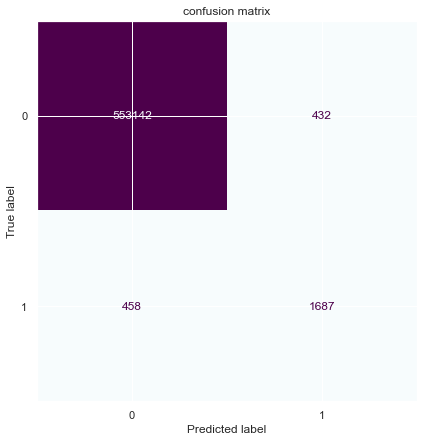

In [101]:
#Ploting the confusion matrix
cm3=confusion_matrix(y_test, y_pred4)
fig, ax = plt.subplots(figsize=(7, 7))
disp =ConfusionMatrixDisplay(confusion_matrix=cm3)
disp.plot(cmap="BuPu",colorbar=False,ax=ax)
plt.title("confusion matrix")
plt.show()

### XG Boost

In [26]:
#get columns to train model
encoder = preprocessing.LabelEncoder()
df["is_fraud_encode"] = encoder.fit_transform(df["is_fraud"])
df_test["is_fraud_encode"] = encoder.fit_transform(df_test["is_fraud"])

x_train=df[['time_hour','age','ownerToMerdist','amt','category_encode']]
y_train=df[['is_fraud_encode']]
#get columns to test model
x_test=df_test[['time_hour','age','ownerToMerdist','amt',"category_encode"]]
y_test=df_test[['is_fraud_encode']]


In [27]:
#train and fit model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_test)

In [28]:
print(f" Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f" precision_score: {precision_score(y_test, y_pred)}")
print(f" recall_score: {recall_score(y_test, y_pred)}")
f1_test_xgb = f1_score(y_test, y_pred)
print('The f1 score for the testing data:', f1_test_xgb)

 Accuracy score: 0.9987601647595278
 precision_score: 0.8982494529540481
 recall_score: 0.7655011655011655
The f1 score for the testing data: 0.8265794110244149


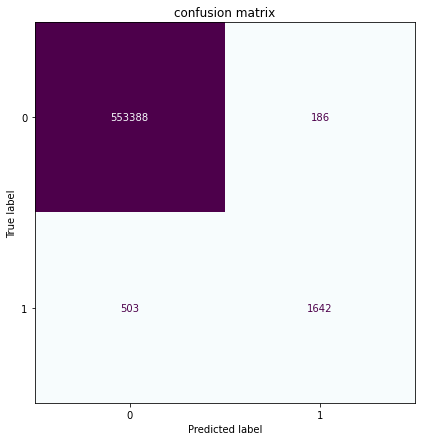

In [29]:
#Ploting the confusion matrix
cmxgb=confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp =ConfusionMatrixDisplay(confusion_matrix=cmxgb)
disp.plot(cmap="BuPu",colorbar=False,ax=ax)
plt.title("confusion matrix")
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

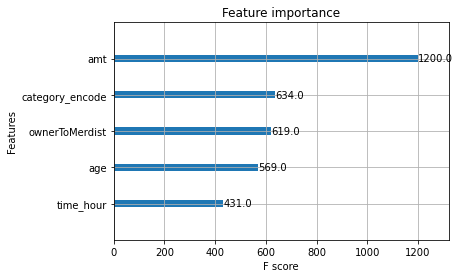

In [30]:
xgb.plot_importance(xgb_model)

In [31]:
y_pred_df=pd.DataFrame(y_pred, columns=['prediction']) 

In [32]:
#merge all DataFrames into one
df_merged = pd.concat([x_test, y_test, y_pred_df], axis=1)


In [33]:
def correct_fraud(true,pred):
    if true==1 and pred==1:
        return 'true_positive'
    elif true==1 and pred ==0:
        return 'false_negative'
    elif true==0 and pred ==1:
        return 'false_positive'
    elif true==0 and pred ==0:
        return 'true_negative'

In [34]:
df_merged['correct_fraud_pred'] = df_merged.apply(lambda x: correct_fraud(x['is_fraud_encode'], x['prediction']), axis=1)

In [35]:
df_merged.correct_fraud_pred.value_counts()

true_negative     553388
true_positive       1642
false_negative       503
false_positive       186
Name: correct_fraud_pred, dtype: int64

In [43]:
df_merged[df_merged['correct_fraud_pred']=='true_positive'].amt.sum().round()

1004195.0

In [42]:
df_merged[df_merged['correct_fraud_pred']=='false_negative'].amt.sum().round()

129130.0

In [38]:
df_merged[df_merged['correct_fraud_pred']=='true_positive'].amt.median()

737.965

In [39]:
df_merged[df_merged['correct_fraud_pred']=='false_negative'].amt.median()

23.92